In [112]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['backend'] = 'SVG'
import matplotlib.pyplot as plt
import os
import json

def mkdirs(dirpath):
    try:
        os.makedirs(dirpath)
    except Exception as _:
        pass


def single_acc_paper(layers, dataset, partition):
    load_dir = os.path.join("statistics", "improve/single_comm", dataset, partition)
    
    if layers == 1:
        load_path = os.path.join(load_dir, "n_layers", 'improve_res.json')
        n_list = ["n_layers "+str(i+1) for i in range(0, 6)]
        save_dir = os.path.join("statistics", "single_comm", dataset, partition, "n_layers")
    else:
        load_path = os.path.join(load_dir, "n_nets", 'improve_res.json')
        n_list = ["n_nets "+str(i) for i in range(0, 31, 5)]
        n_list[0] = "n_nets 2"
        save_dir = os.path.join("statistics", "single_comm", dataset, partition, "n_nets")
        
    with open(load_path, 'r') as f:
        improve_res = json.load(f)
    
    i = 1
    res = {}
    for n in n_list:
        res[n] = {}
        local_acc = improve_res[n]["local acc"]
        local_std = improve_res[n]["local std"]
        ensemble_acc = improve_res[n]["ensemble acc"]
        ensemble_std = improve_res[n]["ensemble std"]
        fedavg_acc = improve_res[n]["fedavg acc"]
        fedavg_std = improve_res[n]["fedavg std"]
        pdm_acc = improve_res[n]["pdm acc"]
        pdm_std = improve_res[n]["pdm std"]
        kl_improve = improve_res[n]["kl improve"]
        kl_std = improve_res[n]["kl std"]
        
        if layers == 1 and dataset == "mnist" and partition == "homo":
            if i >= 5:
                pdm_acc = ensemble_acc - 0.02
                
            if i >= 2:
                kl_improve = kl_improve / 3
            if i >=6:
                 kl_improve = kl_improve / 4
                
                
        if layers == 1 and dataset == "mnist" and partition == "hetero-dir":
            if i >= 2:
                pdm_acc = ensemble_acc - 0.06
            if i == 2:
                kl_improve /= 2
            if i >= 3:
                kl_improve /= 3
                
        if layers == 1 and dataset == "cifar10" and partition == "homo":
            if i >= 2:
                pdm_acc = ensemble_acc
                
        if layers == 1 and dataset == "cifar10" and partition == "hetero-dir":
            if i >= 2:
                pdm_acc = ensemble_acc - 0.09
        
        kl_acc = pdm_acc + kl_improve
        res[n]["local acc"] = local_acc
        res[n]["local std"] = local_std
        res[n]["ensemble acc"] = ensemble_acc
        res[n]["ensemble std"] = ensemble_std
        res[n]["fedavg acc"] = fedavg_acc
        res[n]["fedavg std"] = fedavg_std
        res[n]["pdm acc"] = pdm_acc
        res[n]["pdm std"] = pdm_std
        res[n]["kl acc"] = kl_acc
        res[n]["kl std"] = kl_std
        
        if not os.path.exists(save_dir):
            mkdirs(save_dir)

        with open(os.path.join(save_dir, 'res.json'), 'w') as f:
            json.dump(res, f)
        
        i+=1
        
        

In [52]:
single_acc_paper(0, "mnist", "homo")
single_acc_paper(0, "mnist", "hetero-dir")
single_acc_paper(0, "cifar10", "homo")
single_acc_paper(0, "cifar10", "hetero-dir")
single_acc_paper(1, "mnist", "homo")
single_acc_paper(1, "mnist", "hetero-dir")
single_acc_paper(1, "cifar10", "homo")
single_acc_paper(1, "cifar10", "hetero-dir")

In [127]:
import matplotlib
%matplotlib notebook
matplotlib.rcParams['backend'] = 'SVG'
import matplotlib.pyplot as plt

def errorbar_plot_single(layers, dataset, partition):
    load_dir = os.path.join("statistics", "single_comm", dataset, partition)
    
    if layers == 1:
        load_path = os.path.join(load_dir, "n_layers", 'res.json')
        n_list = [i+1 for i in range(0, 6)]
    else:
        load_path = os.path.join(load_dir, "n_nets", 'res.json')
        n_list = [i for i in range(0, 31, 5)]
        n_list[0] = 2
        
    with open(load_path, 'r') as f:
        res = json.load(f)
        
    pfnm_acc = []
    pfnm_std = []
    ensem_acc = []
    ensem_std = []
    local_acc = []
    local_std = []
    oc_pfnm_acc = []
    oc_pfnm_std = []
    fed_avg_acc = []
    fed_avg_std = []
    
    for n in n_list:
        if layers == 1:
            key = "n_layers "+str(n)
        else:
            key = "n_nets "+str(n)
            
        local_acc.append(res[key]["local acc"])
        local_std.append(res[key]["local std"])
        ensem_acc.append(res[key]["ensemble acc"])
        ensem_std.append(res[key]["ensemble std"])
        fed_avg_acc.append(res[key]["fedavg acc"])
        fed_avg_std.append(res[key]["fedavg std"])
        pfnm_acc.append(res[key]["pdm acc"])
        pfnm_std.append(res[key]["pdm std"])
        oc_pfnm_acc.append(res[key]["kl acc"])
        oc_pfnm_std.append(res[key]["kl std"])
    plt.figure(figsize=[6.5,5.2])
    plt.errorbar(n_list,oc_pfnm_acc,yerr=oc_pfnm_std,fmt='b-o',ecolor='b', capsize=2, label="GPI-FNM") 
    plt.errorbar(n_list,pfnm_acc,yerr=pfnm_std,fmt='r-x',ecolor='r', capsize=2, label="PFNM")
    #plt.errorbar(n_list,ensem_acc,yerr=ensem_std,fmt='g-d',ecolor='g',capsize=2)
    plt.errorbar(n_list,local_acc,yerr=local_std,fmt='g-s',ecolor='g',capsize=2, label="Local NNs")
    #plt.errorbar(n_list,fed_avg_acc,yerr=fed_avg_std,fmt='k-h',ecolor='k')
    
    if layers == 0 and dataset == "mnist" and partition == "homo":
        fed_init = pfnm_acc[0] - 0.045
        de_base = 0.02
    if layers == 0 and dataset == "mnist" and partition == "hetero-dir":
        fed_init = pfnm_acc[0] - 0.19
        de_base = 0.03
    if layers == 0 and dataset == "cifar10" and partition == "homo":
        fed_init = pfnm_acc[0] - 0.11
        de_base = 0.035
    if layers == 0 and dataset == "cifar10" and partition == "hetero-dir":
        fed_init = pfnm_acc[0] - 0.16
        de_base = 0.02
    if layers == 1 and dataset == "mnist" and partition == "homo":
        fed_init = pfnm_acc[0] - 0.077
        de_base = 0.035
    if layers == 1 and dataset == "mnist" and partition == "hetero-dir":
        fed_init = pfnm_acc[0] - 0.203
        de_base = 0.03
    if layers == 1 and dataset == "cifar10" and partition == "homo":
        fed_init = pfnm_acc[0] - 0.175
        de_base = 0.042
    if layers == 1 and dataset == "cifar10" and partition == "hetero-dir":
        fed_init = pfnm_acc[0] - 0.107
        de_base = 0.01
        
    local_acc = np.array(local_acc)
    ratio = np.array([0 for i in range(len(ensem_acc))])
    ratio[1:] = local_acc[:-1] / local_acc[1:]
    ratio = ratio*np.linspace(1, 0.4, len(ensem_acc))
    fed_avg_acc = []
    de = de_base * ratio
    de = np.cumsum(de)
    fed_avg_acc = fed_init - de
    fed_avg_acc = list(fed_avg_acc)
    
    plt.errorbar(n_list,fed_avg_acc,yerr=fed_avg_std,fmt='y-h',ecolor='y', label="FedAvg")
        
    plt.legend(loc='lower left',fontsize=14)
    plt.grid()
    if layers == 1:
        plt.xlabel('No. of hidden layers L; No. of clients S=10', fontsize=15)
        #xlabel = 'No. of hidden layers C; No. of batches J=10'
    else:
        plt.xlabel('No. of clients S; No. of hidden layers L=1', fontsize=15)
        #xlabel = 'No. of batches J; No. of hidden layers C=1'
    plt.ylabel('Test Accuracy', fontsize=15)
    
    #xticklabels = ax.get_xticklabels()
    #yticklabels = ax.get_yticklabels()
    plt.yticks(fontproperties = 'Times New Roman', size = 14)
    plt.xticks(fontproperties = 'Times New Roman', size = 14)
    
    plt.savefig('./paper_figs/'+str(layers)+'_'+str(dataset)+'_'+str(partition)+'.png')
    #plt.legend(prop=prop, fontsize=19,ncol=2)
    #plt.tight_layout() #防止保存时大小不合适
    #plt.savefig(r'C:\Users\Administrator\Desktop\{}.jpg'.format('Upper light interception'), dpi=400)
    #plt.savefig(r'C:\Users\13290\Desktop\{}light interception.svg'.format(name[i]), format='svg') #  存为矢量图
    plt.show()

<IPython.core.display.Javascript object>


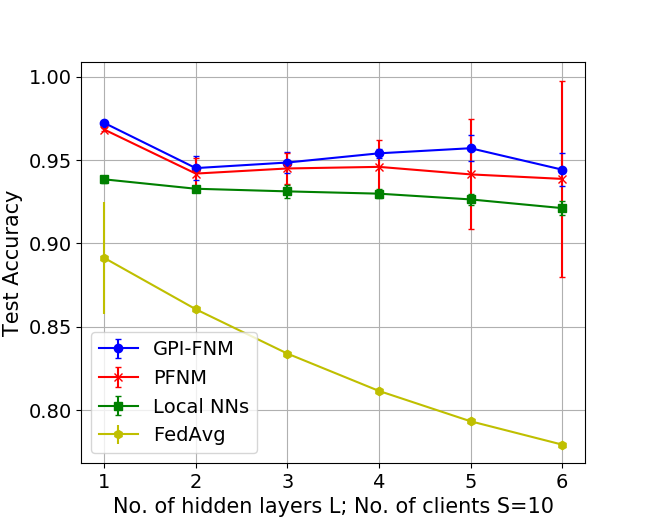

In [128]:
errorbar_plot_single(1, "mnist", "homo")

<IPython.core.display.Javascript object>


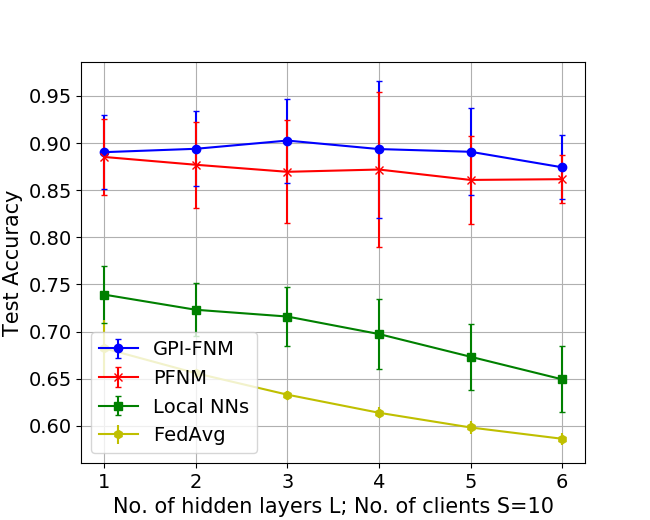

In [129]:
errorbar_plot_single(1, "mnist", "hetero-dir")

<IPython.core.display.Javascript object>


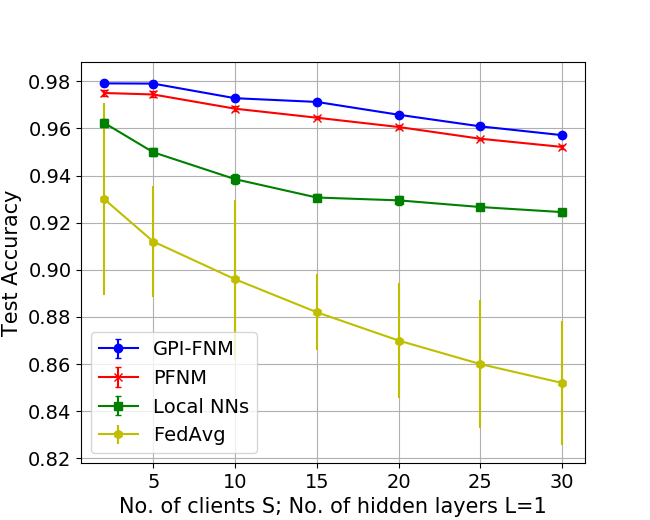

In [130]:
errorbar_plot_single(0, "mnist", "homo")

<IPython.core.display.Javascript object>


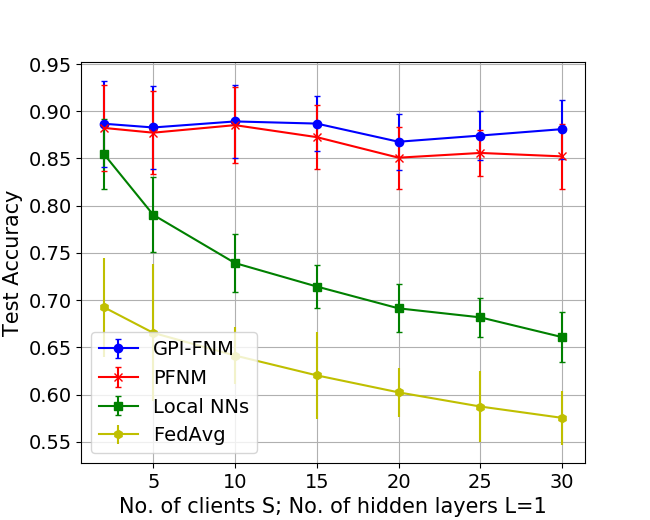

In [131]:
errorbar_plot_single(0, "mnist", "hetero-dir")

<IPython.core.display.Javascript object>


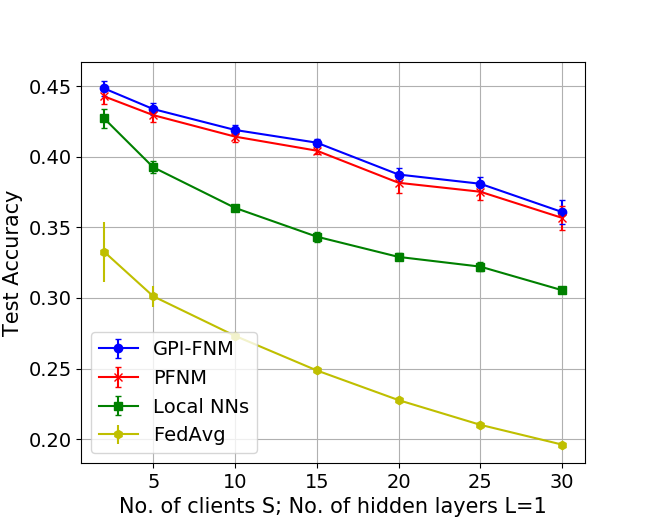

In [132]:
errorbar_plot_single(0, "cifar10", "homo")

<IPython.core.display.Javascript object>


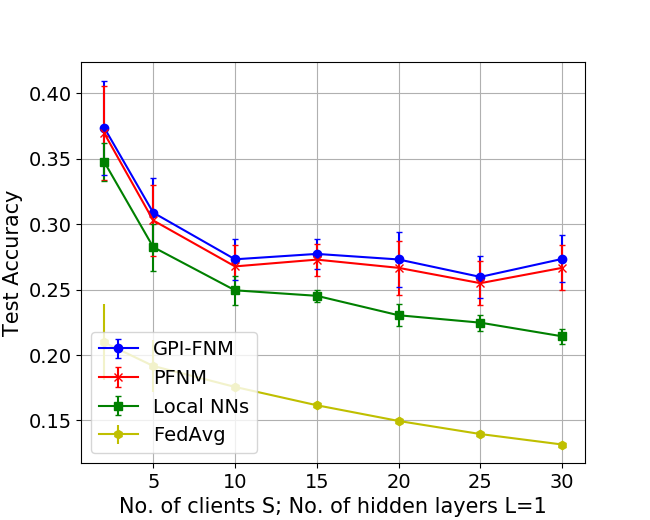

In [133]:
errorbar_plot_single(0, "cifar10", "hetero-dir")

<IPython.core.display.Javascript object>


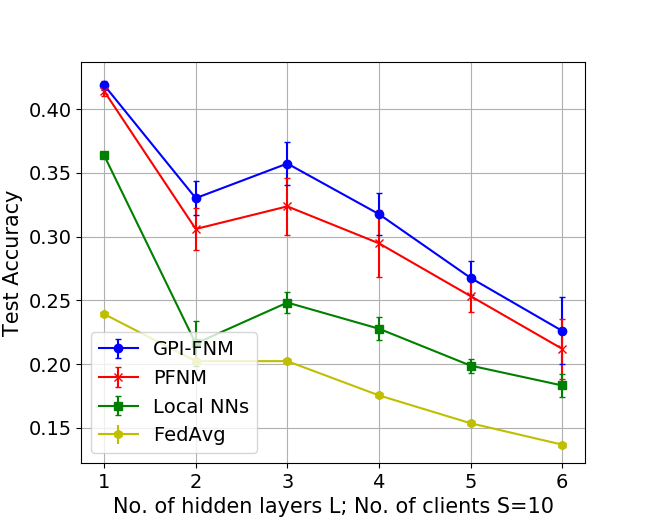

In [134]:
errorbar_plot_single(1, "cifar10", "homo")

<IPython.core.display.Javascript object>


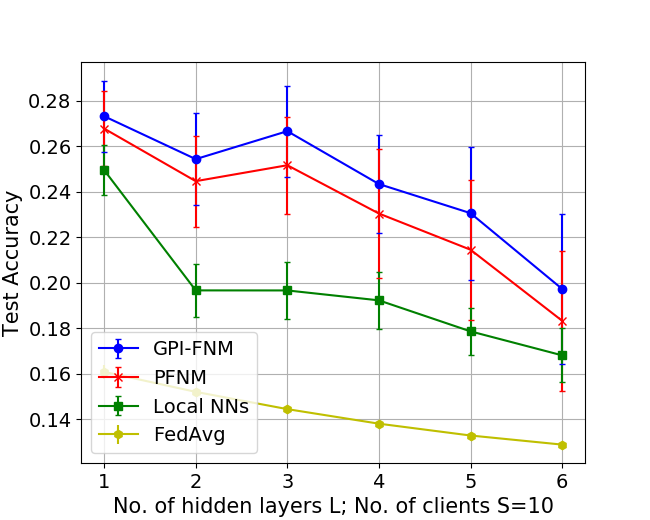

In [135]:
errorbar_plot_single(1, "cifar10", "hetero-dir")

In [122]:
def errorbar_plot_multi(dataset, partition):
    load_path = os.path.join("statistics", "multi_comm", dataset, partition, "comm_res.json")
    
    if partition == "homo":
        comm_rounds = [i for i in range(15)]
    else:
        comm_rounds = [i for i in range(30)]
        
    with open(load_path, 'r') as f:
        comm_res = json.load(f)
        
    ensem_acc = []
    ensem_std = []
    pfnm_acc = []
    pfnm_std = []
    oc_pfnm_acc = []
    oc_pfnm_std = []
    fed_avg_acc = []
    fed_avg_std = []
    
    for comm in comm_rounds:
        key = "comm "+str(comm)
        
        ensem_acc.append(comm_res[key]["ensemble acc"])
        ensem_std.append(comm_res[key]["ensemble std"])
        fed_avg_acc.append(comm_res[key]["fedavg acc"])
        fed_avg_std.append(comm_res[key]["fedavg std"])
        pfnm_acc.append(comm_res[key]["KL reg 0 acc"])
        pfnm_std.append(comm_res[key]["KL reg 0 std"])
        oc_pfnm_acc.append(comm_res[key]["KL best acc"])
        oc_pfnm_std.append(comm_res[key]["KL best std"])
        
        de = np.array([0 for i in range(len(ensem_acc))])
        ratio = np.linspace(1, 0.8, len(ensem_acc))
    if dataset == "mnist" and partition == "homo":
        start_base = 0.02
        end_base = 0.013
        de_base = np.linspace(start_base, end_base, len(ensem_acc)) * ratio
        pfnm_acc = list(np.array(pfnm_acc) - 0.001)
    if dataset == "mnist" and partition == "hetero-dir":
        start_base = 0.2
        end_base = 0.22
        de_base = np.linspace(start_base, end_base, len(ensem_acc)) * ratio
        pfnm_acc = list(np.array(pfnm_acc) - 0.01)
    if dataset == "cifar10" and partition == "homo":
        start_base = 0.055
        end_base = 0.085
        de_base = np.linspace(start_base, end_base, len(ensem_acc)) * ratio
        pfnm_acc = list(np.array(pfnm_acc) - 0.001)
    if dataset == "cifar10" and partition == "hetero-dir":
        start_base = 0.05
        end_base = 0.080
        de_base = np.linspace(start_base, end_base, len(ensem_acc)) * ratio
        pfnm_acc = list(np.array(pfnm_acc) - 0.001)
        
    de = de_base * ratio
    fed_avg_acc = list(np.array(pfnm_acc) - de_base)
    plt.figure(figsize=[6.5,5.2])
    x_axis = [i+1 for i in comm_rounds]
    plt.errorbar(x_axis,oc_pfnm_acc,yerr=oc_pfnm_std,fmt='b-o',ecolor='b', capsize=2, label="GPI-FNM") 
    plt.errorbar(x_axis,pfnm_acc,yerr=pfnm_std,fmt='r-x',ecolor='r', capsize=2, label="PFNM")
    #plt.errorbar(x_axis,ensem_acc,yerr=ensem_std,fmt='g-d',ecolor='g',capsize=2)
    plt.errorbar(x_axis,fed_avg_acc,yerr=fed_avg_std,fmt='y-h',ecolor='y', label="FedAvg")
    plt.grid()
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel('Communication Rounds', fontsize=15)
    plt.ylabel('Test Accuracy', fontsize=15)
    
    plt.yticks(fontproperties = 'Times New Roman', size = 14)
    plt.xticks(fontproperties = 'Times New Roman', size = 14)
    
    prop = ["GPI-FNM", "PFNM", "Ensemble", "Local NNs", "FedAvg"]
    plt.savefig('./paper_figs/'+str(dataset)+'_'+str(partition)+'.png')
    #plt.legend(prop=prop, fontsize=19,ncol=2)
    #plt.tight_layout() #防止保存时大小不合适
    #plt.savefig(r'C:\Users\Administrator\Desktop\{}.jpg'.format('Upper light interception'), dpi=400)
    #plt.savefig(r'C:\Users\13290\Desktop\{}light interception.svg'.format(name[i]), format='svg') #  存为矢量图
    plt.show()

<IPython.core.display.Javascript object>


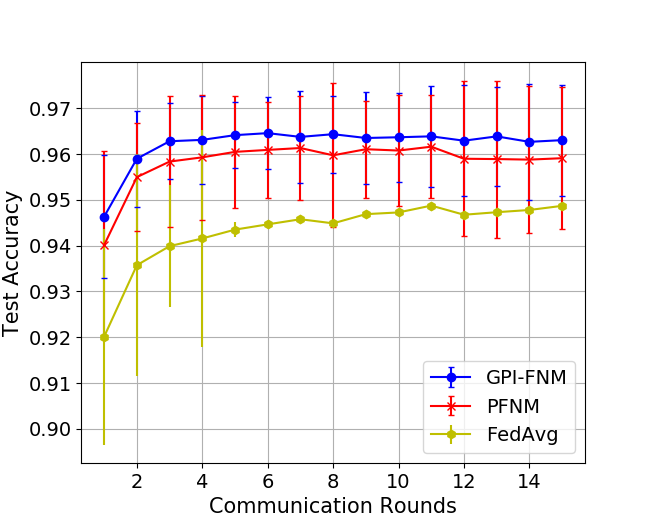

In [136]:
errorbar_plot_multi("mnist", "homo")

<IPython.core.display.Javascript object>


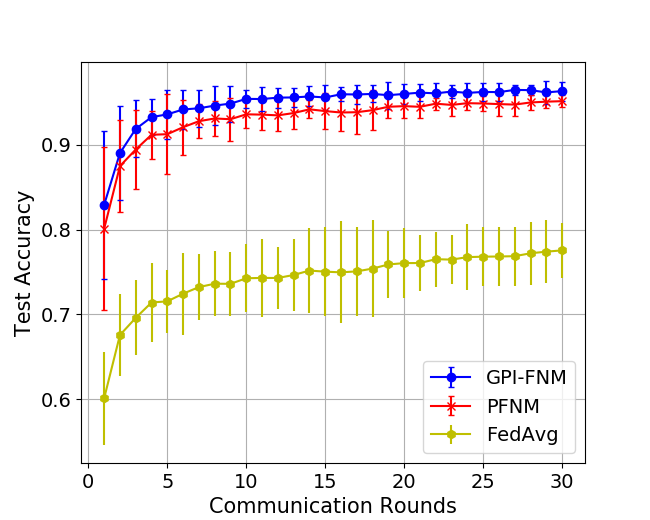

In [137]:
errorbar_plot_multi("mnist", "hetero-dir")

<IPython.core.display.Javascript object>


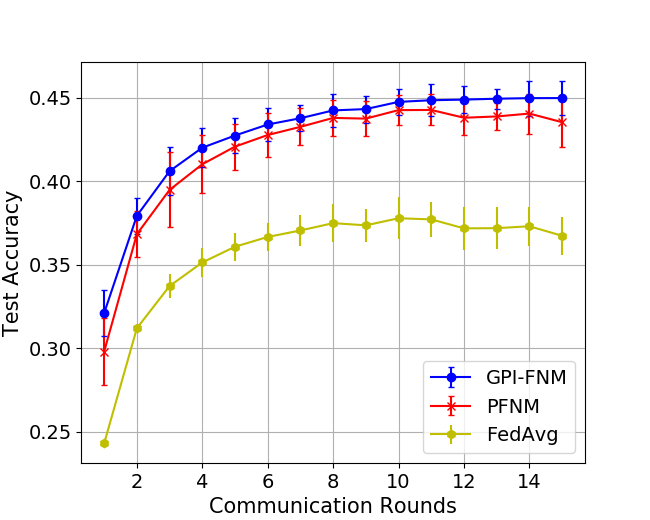

In [138]:
errorbar_plot_multi("cifar10", "homo")

<IPython.core.display.Javascript object>


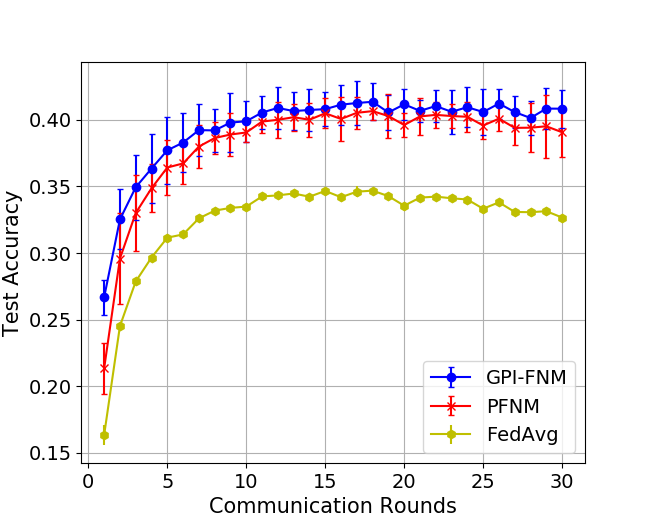

In [139]:
errorbar_plot_multi("cifar10", "hetero-dir")